**V_QCD between two static quark improved action**

In [1]:
import numpy as np
from numpy.random import uniform 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.optimize import least_squares

**functions to generate SU(3) matrices**

In [2]:
def generate_hermitean():
    H=np.zeros((3,3),np.complex_)
    for i in range(3):
        for j in range(3):
            H[i][j]= uniform(-1,1) + 1j*uniform(-1,1)
    H = (1/2)*(H+np.matrix.getH(H))
    return H

In [3]:
def unitarization(H):
    M=np.zeros((3,3),np.complex_)
   
    for n in range(30):
        M+=(((1j*eps)**n)/(np.math.factorial(n))*np.linalg.matrix_power(H,n))
    detM=np.linalg.det(M)**(1/3)
    M=M/detM
    
    return M

In [4]:
def generate_pool(MatList,Nmatrix):
    
    H=np.zeros((3,3),np.complex_)
       
    for i in range(Nmatrix):
        H=generate_hermitean()
        MatList[i]=unitarization(H)
        MatList[Nmatrix+i]=np.matrix.getH(unitarization(H))
        
    return MatList

**lattice generation function**

generate lattice and 4 3x3 identity matrices on each site

In [5]:
def create_lattice(Npoints,dim):
    points = np.empty( (Npoints,Npoints,Npoints,Npoints,dim,3,3), np.complex_ )
    
    #print(lattice)
    for t in range(Npoints):
        for x in range(Npoints):
            for y in range(Npoints):
                for z in range(Npoints):
                    for mu in range(dim):
                        points[t,x,y,z,mu]=np.identity(3,np.complex_)    
    print("finish lattice creation")  #debug
    return points

**coordinate functions**

moving a given point in + direction or - direction

In [6]:
#moving a coordinate up
def up(coordinate,direction,dimensions,N_points):
    coord_up=np.zeros((dimensions),np.int_)
    up=np.zeros((dimensions),np.int_)
    up[direction]=1
    coord_up=(coordinate + up)%N_points
    return coord_up


#moving a coordinate down
def down(coordinate,direction,dimensions,N_points):
    coord_down=np.zeros((dimensions),np.int_)
    down=np.zeros((dimensions),np.int_)
    down[direction]=1
    coord_down=(coordinate-down)%N_points
    return coord_down

**plaquette**

only up and down 1x1 squares

In [7]:
def plaquette(lattice,mu,x,y,z,t):
    
    staple=0. 
    staple_up=0.
    staple_down=0.
    
    point=[x,y,z,t]
    #point(x+mu)
    point_umu=np.zeros((4),np.int_)
    point_umu=up(point,mu,4,N)
    
    for nu in range(4):
        if nu!=mu :
            
            #point(x+nu)
            point_unu=np.zeros((4),np.int_)
            point_unu=up(point,nu,4,N)
            
            #point(x-nu)
            point_dnu=np.zeros((4),np.int_)
            point_dnu=down(point,nu,4,N)
            
            #point(x+mu+nu)
            point_umu_unu=np.zeros((4),np.int_)
            point_umu_unu=up(point_umu,nu,4,N)
            
            #point(x+mu-nu)
            point_umu_dnu=np.zeros((4),np.int_)
            point_umu_dnu=up(point_dnu,mu,4,N)
            
            U_nu_upmu=np.zeros((3,3),np.complex_)
            U_nu=np.zeros((3,3),np.complex_)
            U_nu_downnu=np.zeros((3,3),np.complex_)
            U_mu_downnu=np.zeros((3,3),np.complex_) 
            U_mu_upmudownnu=np.zeros((3,3),np.complex_)
            
            U_nu_upmu=lattice[point_umu[0],point_umu[1],point_umu[2],point_umu[3],nu]
            U_mu_upnu=lattice[point_unu[0],point_unu[1],point_unu[2],point_unu[3],mu]
            U_nu=lattice[point[0],point[1],point[2],point[3],nu]
            U_nu_downnu=lattice[point_dnu[0],point_dnu[1],point_dnu[2],point_dnu[3],nu]
            U_mu_downnu=lattice[point_dnu[0],point_dnu[1],point_dnu[2],point_dnu[3],mu]
            U_nu_upmudownnu=lattice[point_umu_dnu[0],point_umu_dnu[1],point_umu_dnu[2],point_umu_dnu[3],nu]
            
            staple_up=np.dot(np.dot(U_nu_upmu,np.matrix.getH(U_mu_upnu)),np.matrix.getH(U_nu))
            staple_down=np.dot(np.dot(np.matrix.getH(U_nu_upmudownnu),np.matrix.getH(U_mu_downnu)),U_nu_downnu)
            
            staple=staple + staple_up + staple_down
                        

    return staple.copy()

**plaquette improved**

considering also rectangles

In [8]:
def plaquette_improved(lattice,mu,x,y,z,t):
    
    staple_rect=0. 
    
    #point(x)
    point=[x,y,z,t]
    #point(x+mu)
    point_umu=np.zeros((4),np.int_)
    point_umu=up(point,mu,4,N)
    #point(x-mu)
    point_dmu=np.zeros((4),np.int_)
    point_dmu=down(point,mu,4,N)
    #point(x+2mu)
    point_uumu=np.zeros((4),np.int_)
    point_uumu=up(point_umu,mu,4,N)
    for nu in range(4):
        if nu!=mu :
            #point(x+nu)
            point_unu=np.zeros((4),np.int_)
            point_unu=up(point,nu,4,N)
        
            #point(x-nu)
            point_dnu=np.zeros((4),np.int_)
            point_dnu=down(point,nu,4,N)
            
            #point(x+nu+mu)
            point_umu_unu=np.zeros((4),np.int_)
            point_umu_unu=up(point_umu,nu,4,N)
            
            #point(x+mu-nu)
            point_umu_dnu=np.zeros((4),np.int_)
            point_umu_dnu=down(point_umu,nu,4,N)
            
            #point(x+2nu)
            point_uunu=np.zeros((4),np.int_)
            point_uunu=up(point_unu,nu,4,N)
            
            #point(x-2nu)
            point_ddnu=np.zeros((4),np.int_)
            point_ddnu=down(point_dnu,nu,4,N)
            
            #point(x+2mu-nu)
            point_uumu_dnu=np.zeros((4),np.int_)
            point_uumu_dnu=down(point_uumu,nu,4,N)
            
            #point(x+mu-2nu)
            point_umu_ddnu=np.zeros((4),np.int_)
            point_umu_ddnu=down(point_umu_dnu,nu,4,N)
            
            #point(x-mu-nu)
            point_dmu_dnu=np.zeros((4),np.int_)
            point_dmu_dnu=down(point_dmu,nu,4,N)
            
            #point(x-mu+nu)
            point_dmu_unu=np.zeros((4),np.int_)
            point_dmu_unu=up(point_dmu,nu,4,N)
            
            U_mu_upmu=np.zeros((3,3),np.complex_)
            U_nu_upupmu=np.zeros((3,3),np.complex_)
            U_mu_upmuupnu=np.zeros((3,3),np.complex_)
            U_mu_upnu=np.zeros((3,3),np.complex_)
            U_nu=np.zeros((3,3),np.complex_)
            U_nu_upupmudownnu=np.zeros((3,3),np.complex_)
            U_mu_upmudownnu=np.zeros((3,3),np.complex_)
            U_mu_downnu=np.zeros((3,3),np.complex_)
            U_nu_downnu=((3,3),np.complex_)
            U_nu_upmu=np.zeros((3,3),np.complex_)
            U_nu_upmuupnu=((3,3),np.complex_)
            U_mu_upupnu=np.zeros((3,3),np.complex_)
            U_nu_upnu=((3,3),np.complex_)
            U_nu_upmudownnu=np.zeros((3,3),np.complex_)
            U_nu_upmudowndownnu=np.zeros((3,3),np.complex_)
            U_mu_downmuupnu=np.zeros((3,3),np.complex_)
            U_mu_downmudownnu=np.zeros((3,3),np.complex_)
            U_nu_downmudownnu=np.zeros((3,3),np.complex_)
            U_mu_downmu=np.zeros((3,3),np.complex_)
            U_nu_downmu=np.zeros((3,3),np.complex_)
            U_nu_downdownnu=np.zeros((3,3),np.complex_)
            U_mu_downdownnu=np.zeros((3,3),np.complex_)
            
            
            U_mu_upmu=lattice[point_umu[0],point_umu[1],point_umu[2],point_umu[3],mu]
            U_nu_upupmu=lattice[point_uumu[0],point_uumu[1],point_uumu[2],point_uumu[3],nu]
            U_mu_upmuupnu=lattice[point_umu_unu[0],point_umu_unu[1],point_umu_unu[2],point_umu_unu[3],mu]
            U_mu_upnu=lattice[point_unu[0],point_unu[1],point_unu[2],point_unu[3],mu]
            U_nu=lattice[point[0],point[1],point[2],point[3],nu]
            U_nu_upupmudownnu=lattice[point_uumu_dnu[0],point_uumu_dnu[1],point_uumu_dnu[2],point_uumu_dnu[3],nu]
            U_mu_upmudownnu=lattice[point_umu_dnu[0],point_umu_dnu[1],point_umu_dnu[2],point_umu_dnu[3],mu]
            U_mu_downnu=lattice[point_dnu[0],point_dnu[1],point_dnu[2],point_dnu[3],mu]
            U_nu_downnu=lattice[point_dnu[0],point_dnu[1],point_dnu[2],point_dnu[3],nu]
            U_nu_upmu=lattice[point_umu[0],point_umu[1],point_umu[2],point_umu[3],nu]
            U_nu_upmuupnu=lattice[point_umu_unu[0],point_umu_unu[1],point_umu_unu[2],point_umu_unu[3],nu]
            U_mu_upupnu=lattice[point_uunu[0],point_uunu[1],point_uunu[2],point_uunu[3],mu]
            U_nu_upnu=lattice[point_unu[0],point_unu[1],point_unu[2],point_unu[3],nu]
            U_nu_upmudownnu=lattice[point_umu_dnu[0],point_umu_dnu[1],point_umu_dnu[2],point_umu_dnu[3],nu]
            U_nu_upmudowndownnu=lattice[point_umu_ddnu[0],point_umu_ddnu[1],point_umu_ddnu[2],point_umu_ddnu[3],nu]
            U_mu_downmuupnu=lattice[point_dmu_unu[0],point_dmu_unu[1],point_dmu_unu[2],point_dmu_unu[3],mu]
            U_mu_downmudownnu=lattice[point_dmu_dnu[0],point_dmu_dnu[1],point_dmu_dnu[2],point_dmu_dnu[3],mu]
            U_nu_downmudownnu=lattice[point_dmu_dnu[0],point_dmu_dnu[1],point_dmu_dnu[2],point_dmu_dnu[3],nu]
            U_nu_downmu=lattice[point_dmu[0],point_dmu[1],point_dmu[2],point_dmu[3],nu]
            U_mu_downmu=lattice[point_dmu[0],point_dmu[1],point_dmu[2],point_dmu[3],mu]
            U_nu_downdownnu=lattice[point_ddnu[0],point_ddnu[1],point_ddnu[2],point_ddnu[3],nu]
            U_mu_downdownnu=lattice[point_ddnu[0],point_ddnu[1],point_ddnu[2],point_ddnu[3],mu]
            
            
            staple_rect+=np.dot(np.dot(U_mu_upmu,U_nu_upupmu),np.dot(np.matrix.getH(U_mu_upmuupnu),np.dot(np.matrix.getH(U_mu_upnu),np.matrix.getH(U_nu)))) \
                                +np.dot(np.dot(U_mu_upmu,np.matrix.getH(U_nu_upupmudownnu)),np.dot(np.matrix.getH(U_mu_upmudownnu),np.dot(np.matrix.getH(U_mu_downnu),U_nu_downnu))) \
                                +np.dot(np.dot(U_nu_upmu,U_nu_upmuupnu),np.dot(np.matrix.getH(U_mu_upupnu),np.dot(np.matrix.getH(U_nu_upnu),np.matrix.getH(U_nu)))) \
                                +np.dot(np.dot(np.matrix.getH(U_nu_upmudownnu),np.matrix.getH(U_nu_upmudowndownnu)),np.dot(np.matrix.getH(U_mu_downdownnu),np.dot(U_nu_downdownnu,U_nu_downnu))) \
                                +np.dot(np.dot(U_nu_upmu,np.matrix.getH(U_mu_upnu)),np.dot(np.matrix.getH(U_mu_downmuupnu),np.dot(np.matrix.getH(U_nu_downmu),U_mu_downmu))) \
                                +np.dot(np.dot(np.matrix.getH(U_nu_upmudownnu),np.matrix.getH(U_mu_downnu)),np.dot(np.matrix.getH(U_mu_downmudownnu),np.dot(U_nu_downmudownnu,U_mu_downmu)))
    return staple_rect.copy()

**metropolis function**

In [9]:
def lattice_update(lattice,Xs):
    
    n_hits=10
    gamma=0
    gamma_imp=0
    
    for x in range(N):
        for y in range(N):
            for z in range(N):
                for t in range(N):
                    for mu in range(4):
                        
                        coord=[x,y,z,t]
                        gamma=plaquette(lattice,mu,x,y,z,t)
                        gamma_imp=plaquette_improved(lattice,mu,x,y,z,t) 
                        
                        for i in range(n_hits):#do n_hits of metropolis update
                            
                            xi=np.random.randint(2, N_matrix*2)
                            U_old=lattice[coord[0],coord[1],coord[2],coord[3],mu]
                            U_new=np.dot(Xs[xi],U_old)
                            
                            dS = -beta_imp/(3)*(5/(3*u0**4)*np.real(np.trace(np.dot((U_new-U_old),gamma)))-1/(12*u0**6)*np.real(np.trace(np.dot((U_new-U_old),gamma_imp)))) # change in the improved action

                            if dS<0 or np.exp(-dS)>np.random.uniform(0,1):
                                lattice[coord[0],coord[1],coord[2],coord[3],mu] = U_new

V_qcd for **fitting**

In [10]:
#fun to use in fit
def V_exact(x,r,y):
    return x[0]*r-x[1]/r+x[2]-y

#fun generator for static potential given fit parameters
def fun_generator(r,a,b,c):
    return a*r-b/r+c

**prod U, prod U_dags**

products of several link variables in both directions

In [11]:
def prodU(lattice,x,y,z,t,n,f):
    
    productU=np.zeros((3,3),np.complex_)
    U_f=np.zeros((3,3),np.complex_)
    productU=np.identity((3),np.complex_)  
    point=[x,y,z,t]
    point_upf=np.zeros((4),np.int_)
    
    for i in range(n):
        
        if i==0:
            point_upf=point
            U_f=lattice[point_upf[0],point_upf[1],point_upf[2],point_upf[3],f]
            productU=np.dot(productU,U_f) 
        else:
            point_upf=up(point_upf,f,4,N)
            U_f=lattice[point_upf[0],point_upf[1],point_upf[2],point_upf[3],f]
            productU=np.dot(productU,U_f) 
        
    return productU.copy()

In [12]:
def prodUdag(lattice,x,y,z,t,n,f):
    
    productUdagger=np.zeros((3,3),np.complex_) 
    U_fdag=np.zeros((3,3),np.complex_)
    productUdagger=np.identity((3),np.complex_) 
    point=[x,y,z,t]
    point_downf=np.zeros((4),np.int_)
    point_downf=point
    for i in range(n):
        
        point_downf=down(point_downf,f,4,N)
        
        U_fdag=np.matrix.getH(lattice[point_downf[0],point_downf[1],point_downf[2],point_downf[3],f])
        productUdagger=np.dot(productUdagger,U_fdag) 
    return productUdagger.copy()

**Smearing** functions

In [14]:
def Smearing(lattice):
    
    smeared_der=np.zeros((N,N,N,N,4,3,3),np.complex_) 
    smeared_der=Smeared_derivative(lattice) 

    for x in range(N):
        for y in range(N):
            for z in range(N):
                for t in range(N):
                    for mu in range(3):
                        lattice[x,y,z,t,mu]=lattice[x,y,z,t,mu].copy()+eps*a**2*smeared_der[x,y,z,t,mu].copy()
    return lattice.copy()

def Smeared_derivative(lattice):
    
    U_nu=np.zeros((3,3),np.complex_)
    U_mu_upnu=np.zeros((3,3),np.complex_)
    U_nu_upmu=np.zeros((3,3),np.complex_)
    U_mu=np.zeros((3,3),np.complex_)
    U_nu_downnu=np.zeros((3,3),np.complex_)
    U_mu_downnu=np.zeros((3,3),np.complex_)
    U_nu_upmudownnu=np.zeros((3,3),np.complex_)
                            
    derivative_update=np.zeros((N,N,N,N,4,3,3),np.complex_)
    

    for x in range(N):
        for y in range(N):
            for z in range(N):
                for t in range(N):
                    #point(x)
                    point=[x,y,z,t]
                    for mu in range(4):
                        
                        #point(x+mu)
                        point_umu=np.zeros((4),np.int)
                        point_umu=up(point,mu,4,N)
                    
                        for nu in range(4):
                            
                            #point(x+nu)
                            point_unu=np.zeros((4),np.int)
                            point_unu=up(point,nu,4,N)
                            
                            #point(x-nu)
                            point_dnu=np.zeros((4),np.int)
                            point_dnu=down(point,nu,4,N)
                            
                            #point(x+mu-nu)
                            point_umu_dnu=np.zeros((4),np.int)
                            point_umu_dnu=up(point_dnu,mu,4,N)
                            
                            #links for the link product
                            U_nu=lattice[point[0],point[1],point[2],point[3],nu]
                            U_mu_upnu=lattice[point_unu[0],point_unu[1],point_unu[2],point_unu[3],mu]
                            U_nu_upmu=lattice[point_umu[0],point_umu[1],point_umu[2],point_umu[3],nu]
                            U_mu=lattice[point[0],point[1],point[2],point[3],mu]
                            U_nu_downnu=lattice[point_dnu[0],point_dnu[1],point_dnu[2],point_dnu[3],nu]
                            U_mu_downnu=lattice[point_dnu[0],point_dnu[1],point_dnu[2],point_dnu[3],mu]
                            U_nu_upmudownnu=lattice[point_umu_dnu[0],point_umu_dnu[1],point_umu_dnu[2],point_umu_dnu[3],nu]
                            
                            derivative_update[x,y,z,t,mu]+= 1./(u0**2*a**2)*(np.dot(np.dot(U_nu,U_mu_upnu),np.matrix.getH(U_nu_upmu))) \
                                        -2./(a**2)*(U_mu) \
                                        +1./(u0**2*a**2)*(np.dot(np.dot(np.matrix.getH(U_nu_downnu),U_mu_downnu),U_nu_upmudownnu))
                        
    return derivative_update.copy()

**wilson loop**

double: clockwise + anticlockwise

In [15]:
def wilson_double(lattice,time,radius):
    
    prodUt=np.zeros((3,3),np.complex_) 
    prodUr=np.zeros((3,3),np.complex_) 
    prodUt_dag=np.zeros((3,3),np.complex_) 
    prodUr_dag=np.zeros((3,3),np.complex_) 
    prodUt_inv=np.zeros((3,3),np.complex_) 
    prodUr_inv=np.zeros((3,3),np.complex_) 
    prodUt_dag_inv=np.zeros((3,3),np.complex_) 
    prodUr_dag_inv=np.zeros((3,3),np.complex_) 
    
    
    wilson=0.
    point_r=np.zeros((3),np.int_)
    for space in range(3): # 0=x,1=y,2=z
        
        for x in range(N):
            for y in range(N):
                for z in range(N):
                    for t in range(N):
                        time_upT=(t+time)%N
                        point=[x,y,z]
                        point_r=point
                        #incremented coordinates in the spatial direction
                        for r in range(radius):
                            point_r=up(point_r,space,3,N)
                        #counterclockwise
                        prodUt=prodU(lattice,x,y,z,t,time,3) 
                        prodUr=prodU(lattice,x,y,z,time_upT,radius,space) 
                        prodUt_dag=prodUdag(lattice,point_r[0],point_r[1],point_r[2],time_upT,time,3) 
                        prodUr_dag=prodUdag(lattice,point_r[0],point_r[1],point_r[2],t,radius,space) 
                        #clockwise 
                        prodUt_inv=prodU(lattice,point_r[0],point_r[1],point_r[2],t,time,3)
                        prodUr_inv=prodU(lattice,x,y,z,t,radius,space)
                        prodUr_dag_inv=prodUdag(lattice,point_r[0],point_r[1],point_r[2],time_upT,radius,space)
                        prodUt_dag_inv=prodUdag(lattice,x,y,z,time_upT,time,3)
                        
                        wilson+=np.real(np.trace(np.dot(prodUt,np.dot(prodUr,np.dot(prodUt_dag,prodUr_dag))))) \
                                +np.real(np.trace(np.dot(prodUr_inv,np.dot(prodUt_inv,np.dot(prodUr_dag_inv,prodUt_dag_inv)))))
        
    return wilson/9./N**4/2

**main**

input parameters, allocation of arrays

In [16]:
a=0.25 
N=5 
dim=4
eps=1./12.
u0=0.797
beta = 5.5
beta_imp=1.719
r_max=4 #max r + 1
t_max=5 #max t + 1 
N_matrix=200 
N_cf=10 
N_cor=50 

In [17]:

lattice=np.zeros((N,N,N,N,4,3,3),np.complex_)
update_Ms=np.zeros((N_matrix*2,3,3),np.complex_)
lattice_smeared=np.zeros((N,N,N,N,4,3,3),np.complex_)
WL=np.zeros((N_cf,t_max,r_max), np.double) 
smearing_choice=True # as default we apply the smearing


**thermalization**

In [18]:

lattice=create_lattice(N,dim) 
update_Ms=generate_pool(update_Ms,N_matrix)


#thermalization step
for i in tqdm(range(N_cor)):
    lattice_update(lattice,update_Ms)
print("thermalization done")

  0%|          | 0/50 [00:00<?, ?it/s]

finish lattice creation


100%|██████████| 50/50 [02:28<00:00,  2.96s/it]

thermalization done


**computing N_cf configurations**

In [19]:
for alpha in tqdm(range(N_cf)):
    for k in range(5*N_cor):
        lattice_update(lattice,update_Ms)
        
    #smearing
    lattice_smeared=lattice.copy()
    if smearing_choice:
        lattice_smeared=Smearing(lattice_smeared) 
        
    
    for t in range(1,t_max):
        for r in range(1,r_max):
            WL[alpha][t][r]=wilson_double(lattice_smeared,t,r)
print("simulations done")

100%|██████████| 10/10 [2:17:48<00:00, 826.86s/it] 

simulations done


**averages**

and error analysis

In [20]:
WL_avg=np.zeros((t_max,r_max),np.double) 
WL_avg_sq=np.zeros((t_max,r_max),np.double) 
WL_avg_error=np.zeros((t_max,r_max),np.double) 

In [21]:
for t in range(1,t_max):
    for r in range(1,r_max):
        
        for alpha in range(N_cf):
            WL_avg[t][r] += WL[alpha][t][r]
            WL_avg_sq[t][r] += WL[alpha][t][r]**2
        WL_avg[t][r] = WL_avg[t][r]/N_cf
        WL_avg_sq[t][r] = WL_avg_sq[t][r]/N_cf
        WL_avg_error[t][r]= ((WL_avg_sq[t][r]-WL_avg[t][r]**2)/N_cf)**(1/2)

**potential computation**

In [22]:
potential=np.zeros(r_max) 
err_potential=np.zeros(r_max) 
rad=np.zeros(r_max)

In [23]:
#require large t
for r in range(1,r_max):
    potential[r]=np.abs( WL_avg[t_max-2,r]/WL_avg[t_max-1,r])
    err_potential[r] =((WL_avg_error[t_max-1,r]/WL_avg[t_max-1,r])**2+(WL_avg_error[t_max-2,r]/WL_avg[t_max-2,r])**2)**(1/2)*potential[r]
    rad[r] = r

**plotting and fitting**

In [41]:
x=np.ones(3) #initial guess
fit_lsq = least_squares(V_exact, x, loss='soft_l1', args=(rad[1:], potential[1:])) #application of the least square method using the scipy function
r_gen = np.linspace(0.2, 4,500) #generation of points for the graph
V_lsq = fun_generator(r_gen, *fit_lsq.x) #generation of points for the graph


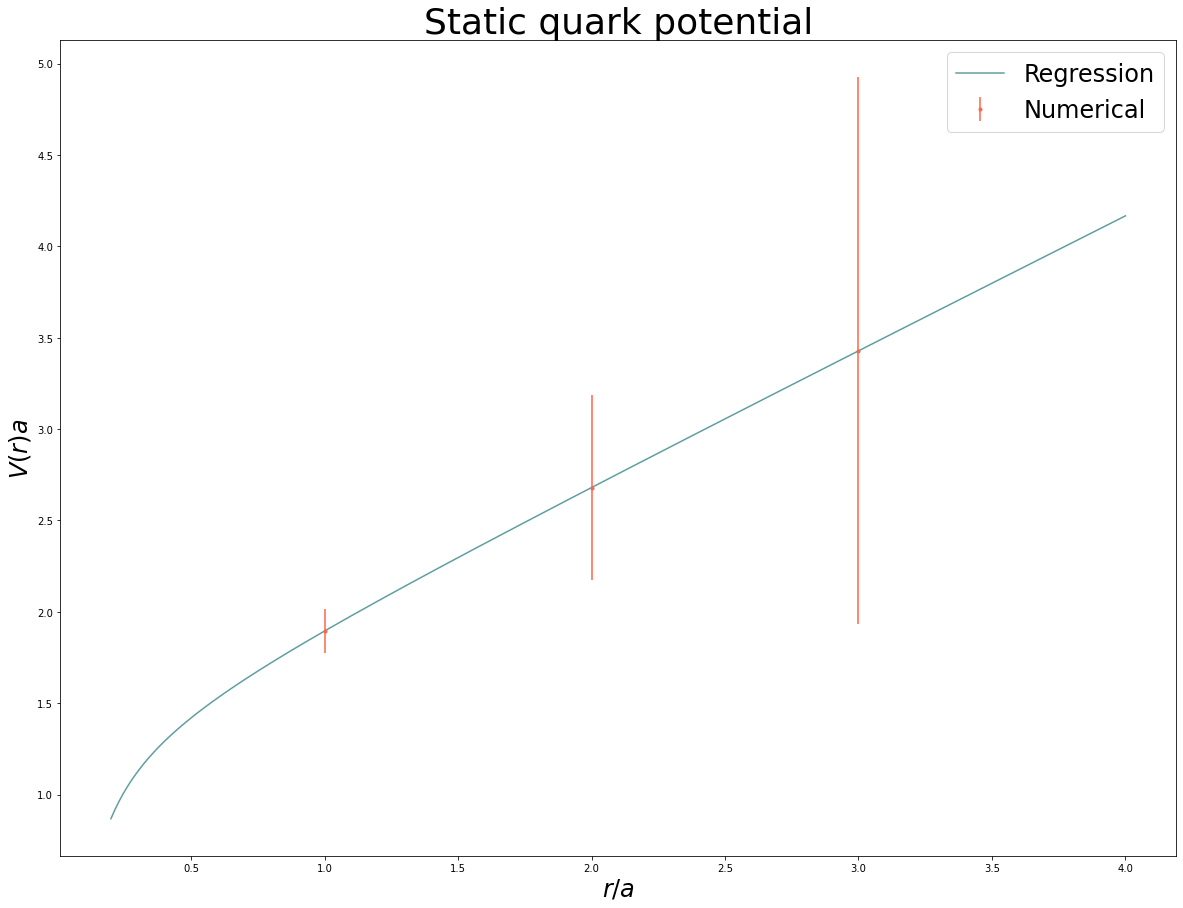

In [42]:
plt.figure(figsize=(20,15))
plt.errorbar(rad[1:], potential[1:], yerr=err_potential[1:], fmt='.', color='tomato', label='Numerical');
plt.plot(r_gen,V_lsq,label='Regression',color='cadetblue')
#plt.axis([0.5,4,0,2.6])
plt.legend(loc='upper right',fontsize=24)
plt.title('Static quark potential',fontsize=36)
plt.xlabel('$r/a$',fontsize=24)
plt.ylabel('$V(r)a$',fontsize=24)
plt.savefig('Vqcd_improved.pdf')  
plt.show()
